## Extremal Training

This notebook walks through the technique detailed in https://arxiv.org/abs/2102.03626

First, we import dependencies.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

Instantiate the model. This model has two layers, with 64 neurons in the first and 32 in the second. We will call this network N1. 

In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer="uniform"))
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer="uniform"))
model.add(tf.keras.layers.Dense(1, kernel_initializer="uniform"))

### Defining the Input-Optimizing Model

This is the class definition for the input-updating network. This will be used later, once the standard model is trained. It is important to note that this network has the same structure as the network N1. This network will be called N2.

In [4]:
class MLP(tf.keras.Model):
    def __init__(self, train_params):
        super().__init__()
        #The layers of this network match the layers of the standard network N1.
        self.L1 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer="uniform")
        self.L2 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="uniform")
        self.OutputLayer = tf.keras.layers.Dense(1, kernel_initializer="uniform")
        
        #Define a tensorflow constant that holds the input of this network.
        self.trainInputs = tf.constant(train_params.numpy())
    
    def updt(self, x, model):
        #Tensorflow uses deferrred initialization, so first run the model to create the input shape
        self(x)
        #Get model weights (which are set as the weights of the dense layers of this new network - this 
        #is why the model structure needs to match the model structure of the standard network N1)
        self.set_weights(model.get_weights())
        #Freeze all the weights of the network so that they are not trained during gradient descent
        self.L1.trainable = False
        self.L2.trainable = False
        self.OutputLayer.trainable = False
        #Set the trainInputs attribute to trainable - it is not exactly a part of the neural network here,
        #but rather just the input
        self.trainInputs = tf.Variable(x.numpy(), trainable=True)
    
    def call(self, x_dummy):
        #x_dummy is not used, but it's needed to use the .call(x) method
        #Run the model with the trainInputs as the input each time .call(x) is used
        x = self.trainInputs
        return self.OutputLayer((self.L2(self.L1(x))))

### Generating the data

This is the function that the network is trained to mimic.

In [5]:
# Generating function
def genFunc(x_feats):
    y = 1 - tf.abs(x_feats[:, 0]) - tf.square(x_feats[:, 1]) - x_feats[:, 2] - tf.exp(x_feats[:, 3]) + tf.random.normal(mean = 0.0, stddev = 0.05, shape = (x_feats[:, 0].shape))
    return y

This code generates the data to be fed into the function we are trying to model (above). A random seed is set to keep the code consistent each time it is run.

In [6]:
def generateData():
    tf.random.set_seed(10)
    x1 = tf.random.uniform(shape=(1000, 1), minval=-1, maxval=1)
    x2 = tf.random.uniform(shape=(1000, 1), minval=-1, maxval=1)
    x3 = tf.random.uniform(shape=(1000, 1), minval=-1, maxval=1)
    x4 = tf.random.uniform(shape=(1000, 1), minval=-1, maxval=1)
    x_feats = tf.concat([x1, x2, x3, x4], 1)
    
    return x_feats

In [7]:
x_feats = generateData()

(array([45., 35., 52., 46., 50., 45., 62., 54., 50., 61., 49., 62., 47.,
        60., 53., 44., 45., 50., 47., 43.]),
 array([-9.9817276e-01, -8.9828891e-01, -7.9840499e-01, -6.9852114e-01,
        -5.9863722e-01, -4.9875337e-01, -3.9886948e-01, -2.9898560e-01,
        -1.9910173e-01, -9.9217854e-02,  6.6602230e-04,  1.0054990e-01,
         2.0043378e-01,  3.0031765e-01,  4.0020153e-01,  5.0008541e-01,
         5.9996927e-01,  6.9985318e-01,  7.9973704e-01,  8.9962095e-01,
         9.9950480e-01], dtype=float32),
 <a list of 20 Patch objects>)

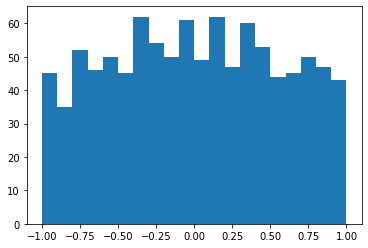

In [8]:
plt.hist(x_feats[:,0], bins=20)

The output needs to be reshaped so that it can be fed into the model.

In [9]:
y = tf.reshape(genFunc(x_feats), shape=(1000,))

### Training the model

Here, the model's learning rate, optimizer and loss function are set. 

In [11]:
learning_rate = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=tf.keras.losses.MSE)

In [12]:
model.fit(x_feats, y, epochs = 80, batch_size=1)

Epoch 1/80
1000/1000 [==============================] - 1s 663us/step - loss: 0.3338
Epoch 2/80
1000/1000 [==============================] - 1s 662us/step - loss: 0.0391
Epoch 3/80
1000/1000 [==============================] - 1s 702us/step - loss: 0.0126
Epoch 4/80
1000/1000 [==============================] - 1s 694us/step - loss: 0.0107
Epoch 5/80
1000/1000 [==============================] - 1s 656us/step - loss: 0.0104
Epoch 6/80
1000/1000 [==============================] - 1s 768us/step - loss: 0.0086
Epoch 7/80
1000/1000 [==============================] - 1s 719us/step - loss: 0.0075
Epoch 8/80
1000/1000 [==============================] - 1s 722us/step - loss: 0.0075
Epoch 9/80
1000/1000 [==============================] - 1s 747us/step - loss: 0.0073
Epoch 10/80
1000/1000 [==============================] - 1s 748us/step - loss: 0.0074
Epoch 11/80
1000/1000 [==============================] - 1s 704us/step - loss: 0.0073
Epoch 12/80
1000/1000 [==============================] - 1s 688

This code allows for a visual check of whether the model is accurately modelling the function we trained it on. 

In [14]:
# Feature generation
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def plotComparision(x_feats, model):
    inputs = ['Carbohydrate', 'Protein', 'Cake', 'Candy']
    numFeats = 4
    feats = [x_feats[0], x_feats[1], x_feats[2], x_feats[3]]
    for i in range(numFeats):
        for j in range(len(feats)):
            feats[j] = tf.zeros(shape=(1000,1))
        
        
        #reassign the ith dimension/feature
        feats[i] = tf.reshape(tf.range(-1, 1, 0.002), shape=(1000, 1))
        x_feats = tf.concat(feats, 1)
        
        plt.figure(i)
        
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        plt.plot(feats[i], genFunc(x_feats), label='Generated Training Data')
        plt.plot(feats[i], model(x_feats), label='Model Prediction')
        
        plt.xlabel(r'\textbf{Intake}')
        plt.ylabel(r'\textbf{Health}')
        plt.title(  
                  r"Health vs. " + inputs[i] + " Intake",
                  fontsize=16, color='black')

        plt.legend()

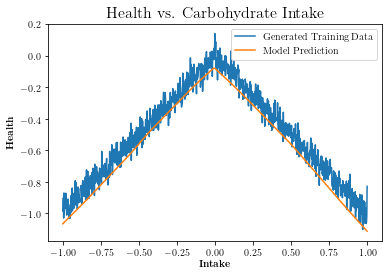

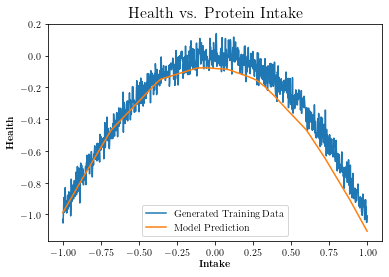

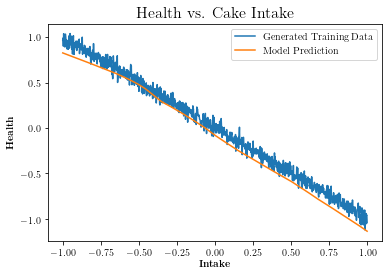

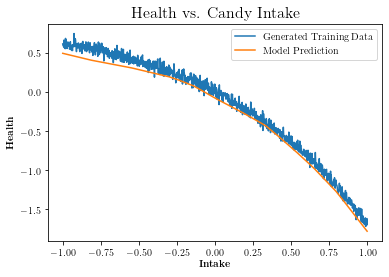

In [15]:
plotComparision(x_feats, model)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


### Optimizing the input

In this section, the an input we give to the optimizing model N2 is going to be optimized. 

First, the four features of the input are randomly generated.

In [17]:
tf.random.set_seed(42)
optimizationModel = MLP(tf.random.normal(shape=(1, 4)))
optimizationModel.updt(tf.random.normal(shape=(1, 4)), model)

In [18]:
inputInit = optimizationModel.trainable_variables[0].numpy().copy()
print(inputInit)

[[ 0.08422458 -0.86090374  0.37812304 -0.00519627]]


In [19]:
model(optimizationModel.trainable_variables[0].numpy())

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.2307081]], dtype=float32)>

The custom loss functions are defined as found in the paper.

In [20]:
def maximizationLoss(y_dummy, y_pred):
       
    result = tf.cond(y_pred <= tf.constant([0.0]), lambda : -10*y_pred + 1, lambda : 1/(tf.square(y_pred) + 1))
    return result

def extrapolationLoss(weights, x):

    mean = tf.reshape(tf.reduce_mean(x, axis=0), shape=(1, 4))
    x_std_expand = tf.reshape(tf.math.reduce_std(x, axis=0), shape=(1, 4))

    #How many std's to allow the extrapolation to be within
    num_stds = 2
    
    #Creates a matrix of zeros with the same shape as the input vector x
    zero_mat = tf.zeros(weights[0].shape)
    
    #At each element, loss_1 is assigned the value of x if the condition is true, else y (which is filled with zeros)
    loss_1 = tf.raw_ops.Select(
        condition = weights[0] < (means - num_stds*x_std_expand), x = weights[0]-mean+num_stds*x_std_expand, y = zero_mat, name=None
    )
    
    loss_2 = tf.raw_ops.Select(
        condition = weights[0] > (means + num_stds*x_std_expand), x = weights[0]-mean-num_stds*x_std_expand, y = zero_mat, name=None
    )
    
    #Return squared loss 
    return (tf.reduce_sum(tf.square(loss_1)) + tf.reduce_sum(tf.square(loss_1)))

In [21]:
means = tf.reshape(tf.reduce_mean(x_feats, axis=0), shape=(1, 4)).numpy()
stds = tf.reshape(tf.math.reduce_std(x_feats, axis=0), shape=(1, 4)).numpy()

stds, means

(array([[0.55495155, 0.5766216 , 0.5774474 , 0.56745553]], dtype=float32),
 array([[ 0.0068051 , -0.02758399,  0.0049364 ,  0.00633236]],
       dtype=float32))

In [22]:
extrapolationLoss(optimizationModel.trainable_variables, x_feats)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In addition to the optimizer, add the custom losses as follows. A default loss can be added in the *compile* method, and it will automatically receive y_true and y_pred (in that order). A custom loss with custom inputs is added using the *add_loss* method. 

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
optimizationModel.compile(optimizer=opt, loss=maximizationLoss)

optimizationModel.add_loss(
    lambda : extrapolationLoss(optimizationModel.trainable_variables, x_feats)
)

In [24]:
optimizationModel.fit(x_feats, y, epochs = 50, batch_size=1)

Epoch 1/50
1000/1000 [==============================] - 1s 593us/step - loss: 5.1919
Epoch 2/50
1000/1000 [==============================] - 1s 583us/step - loss: 0.9997
Epoch 3/50
1000/1000 [==============================] - 1s 637us/step - loss: 0.9992
Epoch 4/50
1000/1000 [==============================] - 1s 632us/step - loss: 0.9939
Epoch 5/50
1000/1000 [==============================] - 1s 643us/step - loss: 0.9439
Epoch 6/50
1000/1000 [==============================] - 1s 919us/step - loss: 0.7475
Epoch 7/50
1000/1000 [==============================] - 1s 606us/step - loss: 0.4902
Epoch 8/50
1000/1000 [==============================] - 1s 603us/step - loss: 0.3618
Epoch 9/50
1000/1000 [==============================] - 1s 665us/step - loss: 0.3139
Epoch 10/50
1000/1000 [==============================] - 1s 755us/step - loss: 0.3115
Epoch 11/50
1000/1000 [==============================] - 1s 908us/step - loss: 0.3112
Epoch 12/50
1000/1000 [==============================] - 1s 786

In [25]:
optimizationModel.trainable_variables[0].numpy()

array([[ 0.10853714,  0.08773184, -1.1939849 , -1.1601902 ]],
      dtype=float32)

In [26]:
inputInit

array([[ 0.08422458, -0.86090374,  0.37812304, -0.00519627]],
      dtype=float32)

In [27]:
y = 1 - abs(-0.16720928) - (-0.0865911)**2 - (-1.1929115) - np.exp(-1.1527836)
print("Maximum from optimized input is " + str(y.round(3)))

Maximum from optimized input is 1.702
